# Labels Addition

Purpose of this notebook as to add already classified labels
to the dataset. This has been done
http://physics.muni.cz/~ssa/archive/.

## Load All Data

In [1]:
import os
import h5py
import re
import random
import astropy.io.fits
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
f = h5py.File('data.hdf5')
spectra = f['spectra']

## Load Labeled Data

In [3]:
def gen_fits_paths(path):
    """Returns a generator of paths to fits files."""
    return (os.path.join(dirpath, filename)
            for dirpath, _, filenames in os.walk(path)
            for filename in filenames
            if filename.endswith('.fits'))

In [4]:
def get_fits_name(path):
    return os.path.splitext(os.path.split(path)[1])[0]

In [5]:
pattern = re.compile('/(\d+)/')
def fits_data(path):
    with astropy.io.fits.open(path) as hdulist:
        data = hdulist[1].data.copy()
    return {
        'wave': data['WAVE'],
        'flux': data['FLUX'],
        'label': int(pattern.search(path).group(1)) - 1
    }

In [6]:
labeled_spectra = {
    get_fits_name(path): fits_data(path)
    for path in gen_fits_paths('labeled/archive_1_5/')
}

## Identify the Intersection

In [7]:
# find intersection of labeled and not labeled data
intersection = set(labeled_spectra) & set(spectra)
len(labeled_spectra), len(intersection)

(1726, 1722)

In [8]:
# these are not in intersection
difference = set(labeled_spectra) - set(spectra)
difference

{'400norm', 'pi240043', 'test1', 'test2'}

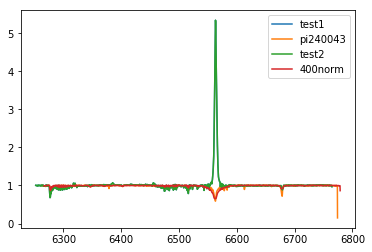

In [9]:
for spectrum in difference:
    plt.plot(
        labeled_spectra[spectrum]['wave'],
        labeled_spectra[spectrum]['flux'],
        label=spectrum,
    )
plt.legend()

## Add Labels

In [10]:
if 'resampled/labels' in f:
    del f['resampled/labels']

idents = f['resampled/idents']
labels = f.create_dataset('resampled/labels', idents.shape, dtype='i')
for idx, ident in enumerate(idents):
    if ident in labeled_spectra:
        labels[idx] = labeled_spectra[ident]['label']
    else:
        labels[idx] = -1

## Visualization

In [11]:
labels, index, counts = np.unique(labels, return_index=True, return_counts=True)
labels, index, counts

(array([-1,  0,  1,  2,  3,  4], dtype=int32),
 array([   0, 4087, 4042,   11, 4043,   10]),
 array([11487,   176,   172,  1186,    56,   132]))

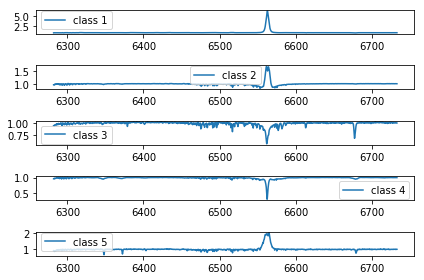

In [12]:
fluxes = f['resampled/fluxes']
wave = f['resampled/wave'][:]
for label, idx in enumerate(index[1:]):
    plt.subplot(5, 1, label + 1)
    plt.plot(wave, fluxes[idx], label='class {}'.format(label + 1))
    plt.legend()
plt.tight_layout()

## Save the Labeled Data

In [13]:
f.close()